## Load some libraries

In [1]:
!pip install rich

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import os
from pystac_client import Client as pystacclient
from odc import stac as odc_stac
from odc.geo import geobox
import datetime
import rich.table
import rioxarray as rxr
import xarray as xr
import dask
from dask.distributed import Client

## <a id='startup'></a> Let's start with some relevant settings

To identify the relevant STAC collection, visit [terrabyte STAC Browser ](https://stac.terrabyte.lrz.de/browser/) with your browser.


In [2]:
stacUrl = "https://stac.terrabyte.lrz.de/public/api" # currently working STAC API endpoint
collection = ["modis-13a2-061"] 
bbox = [11.2, 47.5, 11.5, 48] 
date = ["2020-01-01", "2020-12-31"]

## Search the STAC API

We will open the terrabyte STAC API catalog...

In [3]:
catalog = pystacclient.open(
    url=stacUrl
)

... and donduct a search query

In [5]:
stac_items = catalog.search(
    collections=collection, 
    datetime=date,
    bbox=bbox,
    query={
        "platform": dict(eq="terra"),
        #"modis:vertical-tile": dict(eq="4")
    }
).item_collection()

print(f"Found {len(stac_items):d} MOD13A3 datasets with platform = terra, in the given bounding box and in the date range between 2020-01-01 and 2020-12-31")

Found 24 MOD13A3 datasets with platform = terra, in the given bounding box and in the date range between 2020-01-01 and 2020-12-31


## Let's have a look at the first STAC item in the list

In [6]:
for i in stac_items: 
    print(i.id)

MOD13A2.A2020353.h18v04.061.2021012025120
MOD13A2.A2020337.h18v04.061.2021011165909
MOD13A2.A2020321.h18v04.061.2020357073956
MOD13A2.A2020305.h18v04.061.2020353091334
MOD13A2.A2020289.h18v04.061.2020352191548
MOD13A2.A2020273.h18v04.061.2020349193930
MOD13A2.A2020257.h18v04.061.2020347061807
MOD13A2.A2020241.h18v04.061.2020346094325
MOD13A2.A2020225.h18v04.061.2020344192954
MOD13A2.A2020209.h18v04.061.2020342013547
MOD13A2.A2020193.h18v04.061.2020340132348
MOD13A2.A2020177.h18v04.061.2020340101245
MOD13A2.A2020161.h18v04.061.2020336155445
MOD13A2.A2020145.h18v04.061.2020335212825
MOD13A2.A2020129.h18v04.061.2020334194837
MOD13A2.A2020113.h18v04.061.2020333061529
MOD13A2.A2020097.h18v04.061.2020332095448
MOD13A2.A2020081.h18v04.061.2020335013531
MOD13A2.A2020065.h18v04.061.2020330161755
MOD13A2.A2020049.h18v04.061.2020335000209
MOD13A2.A2020033.h18v04.061.2020329061443
MOD13A2.A2020017.h18v04.061.2020328133729
MOD13A2.A2020001.h18v04.061.2020326033640
MOD13A2.A2019353.h18v04.061.202032

In [7]:
stac_items[0]

<Item id=MOD13A2.A2020353.h18v04.061.2021012025120>

In [8]:
item = stac_items[0]

t = rich.table.Table("Key", "Title")
for key, asset in stac_items[0].assets.items():
    t.add_row(key, asset.title)
t

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key                       ┃ Title                                             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ EVI                       │                                                   │
│ hdf                       │ Source data containing all bands                  │
│ NDVI                      │                                                   │
│ metadata                  │ Federal Geographic Data Committee (FGDC) Metadata │
│ VI_Quality                │                                                   │
│ MIR_reflectance           │                                                   │
│ NIR_reflectance           │                                                   │
│ red_reflectance           │                                                   │
│ blue_reflectance          │                                                   │
│ sun_zenith_angle          │                                                   │
│ pixel_reliability         │                                                   │
│ view_zenith_angle         │                                                   │
│ relative_azimuth_angle    │                                                   │
│ composite_day_of_the_year │                                                   │
└───────────────────────────┴───────────────────────────────────────────────────┘

## Define and start Dask client

In [9]:
dir_out = '~/xarray-dask-tutorial'
dask_tmpdir = os.path.join(dir_out, 'scratch', 'localCluster')
dask_chunksize = 1200
# from testins running without threads is the faster option 
dask_threads = 1

In [10]:
host = os.getenv('host')
jl_port = os.getenv('port')
#create to URL to point to the jupyter-server-proxy
dask_url = f'https://portal.terrabyte.lrz.de/node/{host}/{jl_port}'+'/proxy/{port}/status'
#dask will insert the final port choosen by the Cluster 

dask.config.set({'temporary_directory': dask_tmpdir,
                 'distributed.dashboard.link': dask_url})

#some settings to increase network timeouts and allow the dashboard to plot larger graphs
dask.config.set({'distributed.comm.timeouts.tcp': '180s',
                 'distributed.comm.timeouts.connect': '120s',
                 'distributed.dashboard.graph-max-items': 55000,
                 'distributed.deploy.lost-worker-timeout': '90s',
                 'distributed.scheduler.allowed-failures': 180,
                 })
#we set the dashboard address for dask to choose a free random port, so there is no error with multiple dasks running on same node 
client = Client(threads_per_worker=dask_threads, dashboard_address="127.0.0.1:0")
client

<Client: 'tcp://127.0.0.1:33201' processes=16 threads=16, memory=50.00 GiB>

## Let's load, reproject and scale the data...
### 1. Extract the scale and nodata values for NDVI and EVI.

In [11]:
raster_info_NDVI = stac_items[1].assets["NDVI"].extra_fields["raster:bands"]

print(raster_info_NDVI)
print(raster_info_NDVI[0]["scale"])
print(raster_info_NDVI[0]["nodata"])

[{'unit': 'NDVI', 'scale': 0.0001, 'nodata': -3000, 'offset': 0, 'data_type': 'int16'}]
0.0001
-3000


In [12]:
raster_info_EVI = stac_items[1].assets["EVI"].extra_fields["raster:bands"]

print(raster_info_EVI)
print(raster_info_EVI[0]["scale"])
print(raster_info_EVI[0]["nodata"])

[{'unit': 'EVI', 'scale': 0.0001, 'nodata': -3000, 'offset': 0, 'data_type': 'int16'}]
0.0001
-3000


### 2. Load the data into a datacube and reproject and scale them.

In [13]:
cube = odc_stac.load(stac_items,
                     chunks={'x': dask_chunksize, 'y': dask_chunksize},  # spatial chunking
                     anchor=geobox.AnchorEnum.FLOATING,  # preserve original pixel grid
                     bands=["EVI", "NDVI"]
)
cube

<xarray.Dataset>
Dimensions:      (y: 1200, x: 1200, time: 24)
Coordinates:
  * y            (y) float64 5.559e+06 5.558e+06 ... 4.449e+06 4.448e+06
  * x            (x) float64 463.3 1.39e+03 2.317e+03 ... 1.111e+06 1.111e+06
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2019-12-19 2020-01-01 ... 2020-12-18
Data variables:
    EVI          (time, y, x) int16 dask.array<chunksize=(1, 1200, 1200), meta=np.ndarray>
    NDVI         (time, y, x) int16 dask.array<chunksize=(1, 1200, 1200), meta=np.ndarray>

## ... and plot the NDVI and EVI time-series

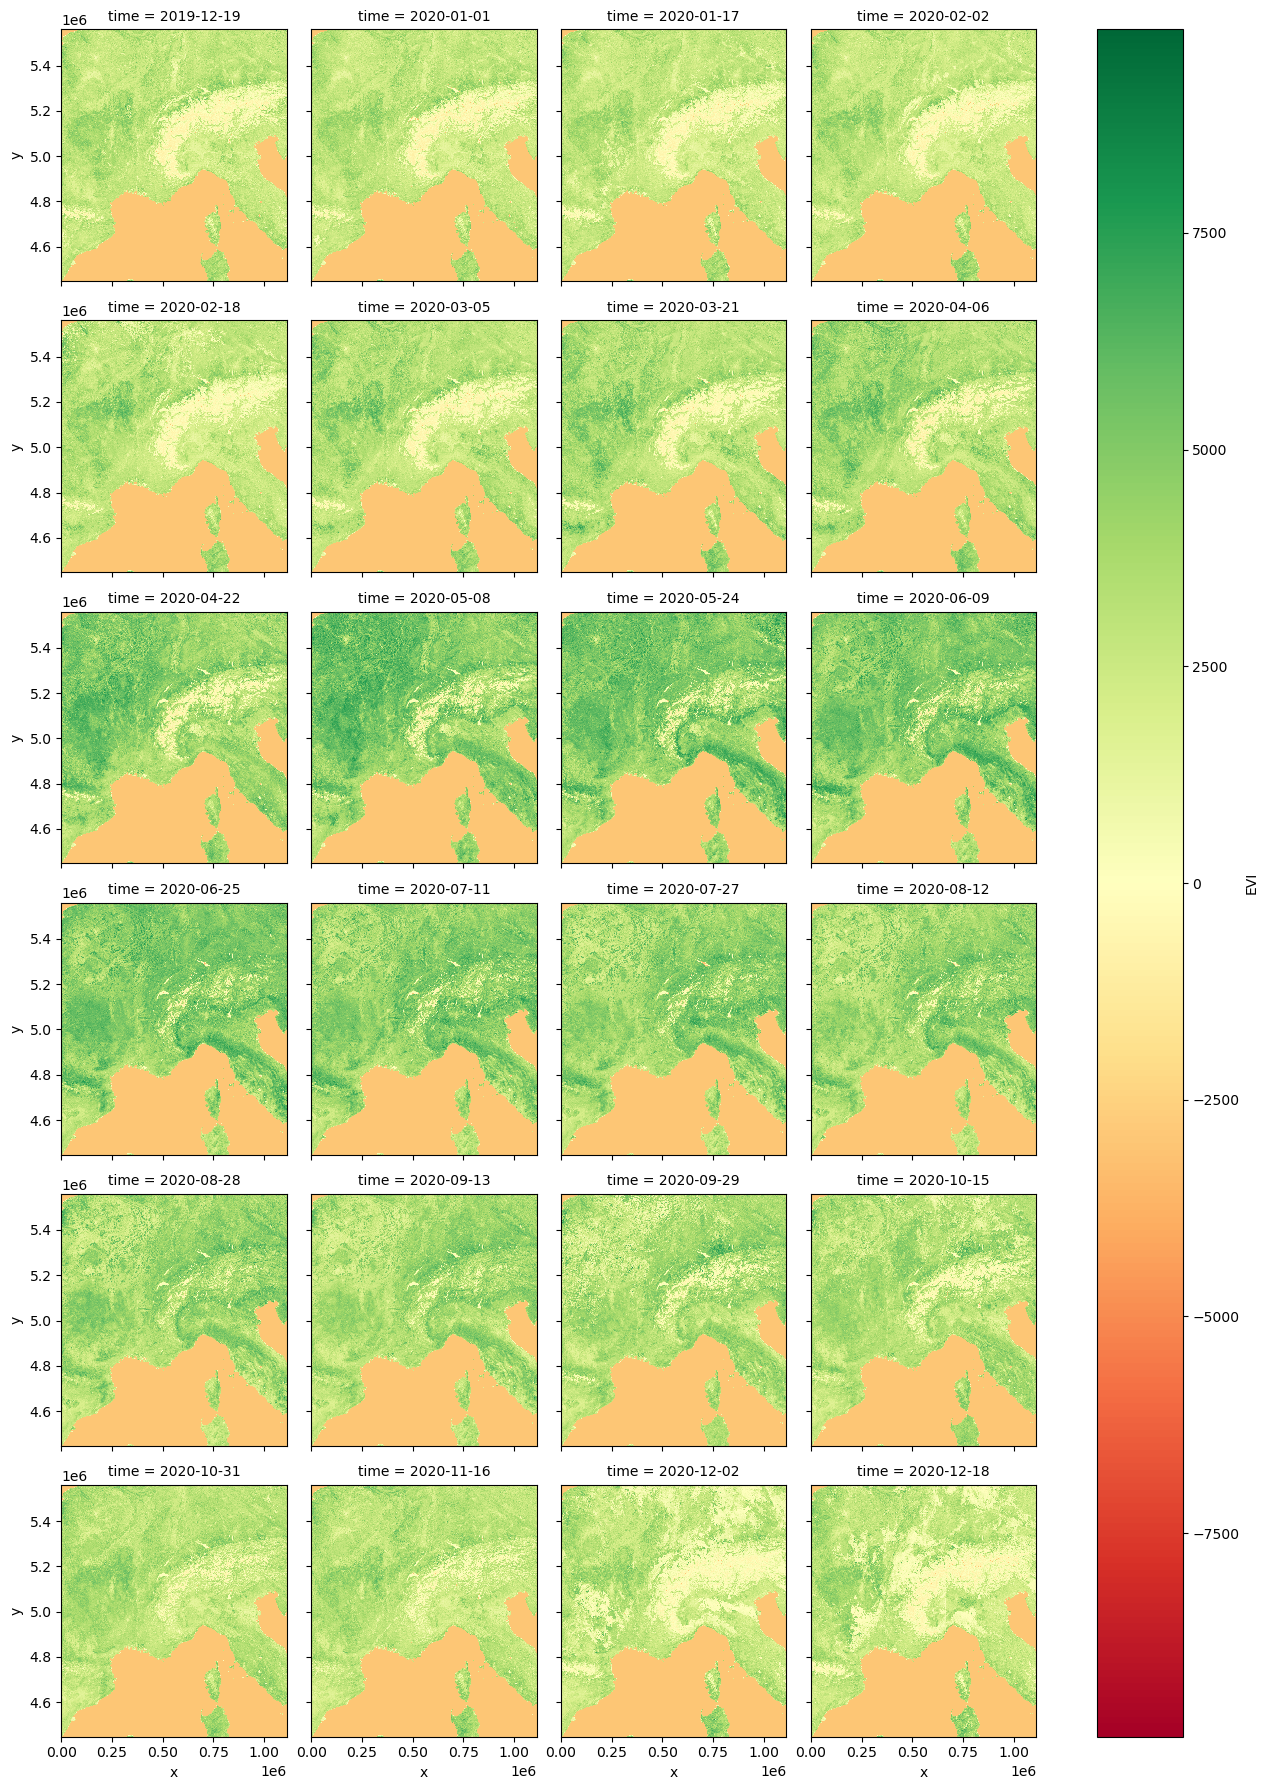

In [14]:
cube['EVI'].plot.imshow(cmap="RdYlGn", col="time", col_wrap=4);

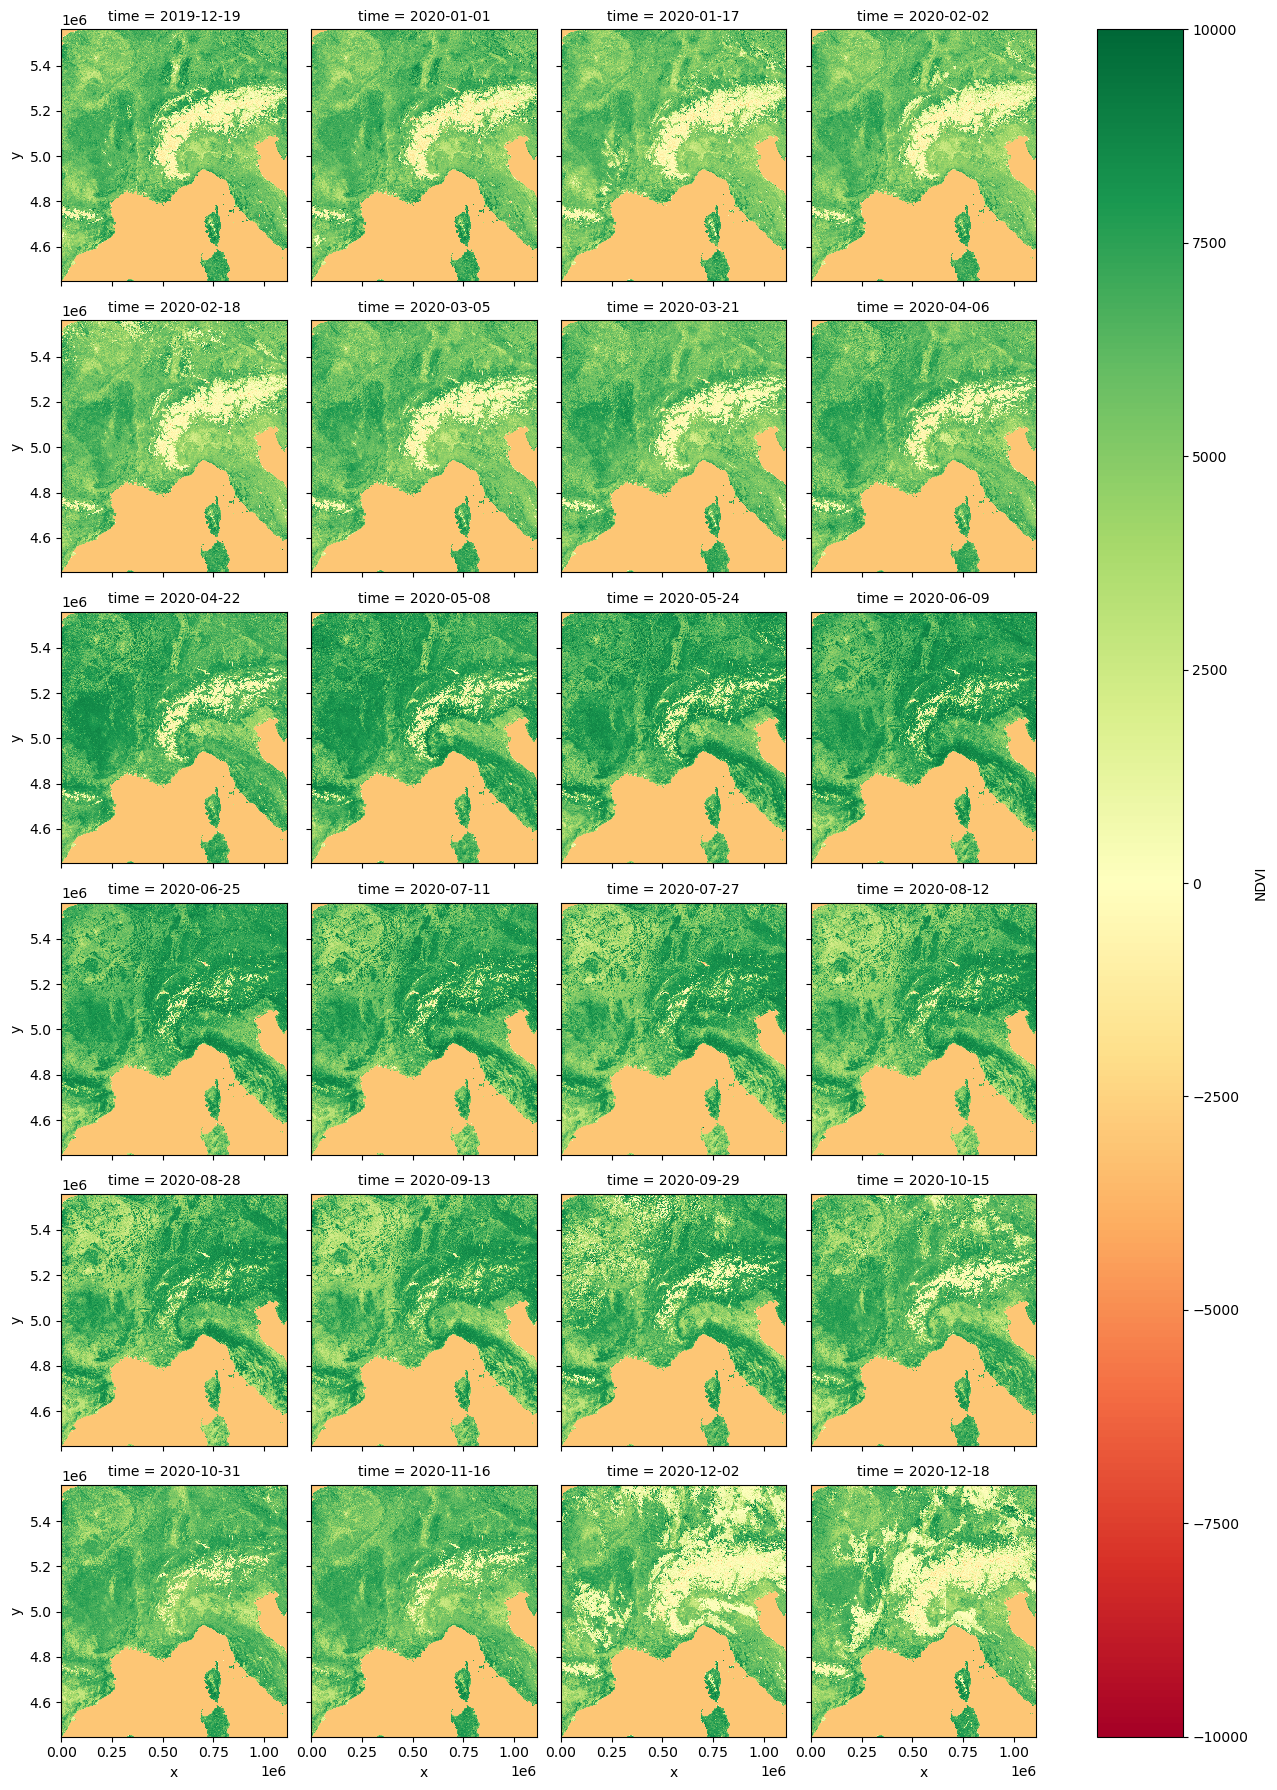

In [15]:
cube['NDVI'].plot.imshow(cmap="RdYlGn", col="time", col_wrap=4);

## Close Dask client

In [16]:
client.close()